In [ ]:
try:
    import ssm_jax
except:
    %pip install -U -q git+https://github.com/probml/ssm-jax.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 185 kB 7.8 MB/s 
     |████████████████████████████████| 115 kB 45.9 MB/s 
     |████████████████████████████████| 85 kB 3.1 MB/s 
     |████████████████████████████████| 145 kB 54.0 MB/s 
     |████████████████████████████████| 128 kB 51.7 MB/s 
     |████████████████████████████████| 237 kB 52.4 MB/s 
     |████████████████████████████████| 51 kB 6.9 MB/s 


In [ ]:
import numpy as np
import jax
from jax import numpy as jnp
from jax import scipy as jsc
from jax import random as jr
from jax import vmap, tree_map, config, block_until_ready
from jax.lax import associative_scan
from matplotlib import pyplot as plt

# Parallel filtering and smoothing in a linear Gaussian state-space model

This code borrows heavily from this [example notebook](https://github.com/EEA-sensors/sequential-parallelization-examples/blob/main/python/temporal-parallelization-bayes-smoothers/parallel_kalman_jax.ipynb) from [Adrien Correnflos](https://github.com/AdrienCorenflos). Some small changes have been made here and it has been updated to work with ssm-jax.

The parallel inference functions implemented below are available in the ssm_jax library in `ssm_jax.linear_gaussian_ssm.parallel_inference`.

In [ ]:
from ssm_jax.linear_gaussian_ssm.inference import LGSSMParams, lgssm_filter, lgssm_smoother, lgssm_sample
from ssm_jax.linear_gaussian_ssm.models import LinearGaussianSSM

## Model
The model is a simple tracking model (see Example 3.6 in *Bayesian Filtering and Smoothing* (S. Särkkä, 2013).

In [ ]:
dt = 0.1
F = jnp.eye(4) + dt * jnp.eye(4, k=2)
Q = 1. * jnp.kron(jnp.array([[dt**3/3, dt**2/2],
                      [dt**2/2, dt]]), 
                 jnp.eye(2))
H = jnp.eye(2, 4)
R = 0.5 ** 2 * jnp.eye(2)
μ0 = jnp.array([0.,0.,1.,-1.])
Σ0 = jnp.eye(4)

In [ ]:
latent_dim = 4
observation_dim = 2
input_dim = 1

lgssm_params = LGSSMParams(
    initial_mean = μ0,
    initial_covariance = Σ0,
    dynamics_matrix = F,
    dynamics_input_weights = jnp.zeros((latent_dim,input_dim)),
    dynamics_bias = jnp.zeros(latent_dim),
    dynamics_covariance = Q,
    emission_matrix = H,
    emission_input_weights = jnp.zeros((observation_dim, input_dim)),
    emission_bias = jnp.zeros(observation_dim),
    emission_covariance = R
)

In [ ]:
num_timesteps = 100
key = jr.PRNGKey(0)
inputs = jnp.zeros((num_timesteps,input_dim))

key, subkey = jr.split(key)
z,emissions = lgssm_sample(subkey,lgssm_params,num_timesteps, inputs)
ssm_posterior = lgssm_smoother(lgssm_params, emissions, inputs)

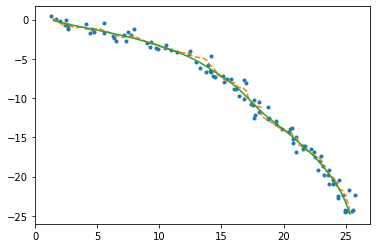

In [ ]:
plt.plot(*emissions.T,'.');
plt.plot(*ssm_posterior.filtered_means[:,:2].T, '--');
plt.plot(*ssm_posterior.smoothed_means[:,:2].T);

## Parallel Inference

### Filtering

In [ ]:
def first_filtering_element(params, y):
    F = params.dynamics_matrix
    H = params.emission_matrix
    Q = params.dynamics_covariance
    R = params.emission_covariance
    
    S = H @ Q @ H.T + R
    CF, low = jsc.linalg.cho_factor(S)

    m1 = F @ params.initial_mean
    P1 = F @ params.initial_covariance @ F.T + Q
    S1 = H @ P1 @ H.T + R
    K1 = jsc.linalg.solve(S1, H @ P1, assume_a="pos").T  

    A = jnp.zeros_like(F)
    b = m1 + K1 @ (y - H @ m1)
    C = P1 - K1 @ S1 @ K1.T

    eta = F.T @ H.T @ jsc.linalg.cho_solve((CF, low), y)
    J = F.T @ H.T @ jsc.linalg.cho_solve((CF, low), H @ F)
    return A, b, C, J, eta


def generic_filtering_element(params, y):
    F = params.dynamics_matrix
    H = params.emission_matrix
    Q = params.dynamics_covariance
    R = params.emission_covariance
    
    S = H @ Q @ H.T + R
    CF, low = jsc.linalg.cho_factor(S)  
    K = jsc.linalg.cho_solve((CF, low), H @ Q).T  
    A = F - K @ H @ F
    b = K @ y
    C = Q - K @ H @ Q

    eta = F.T @ H.T @ jsc.linalg.cho_solve((CF, low), y)
    J = F.T @ H.T @ jsc.linalg.cho_solve((CF, low), H @ F)
    return A, b, C, J, eta

In [ ]:
def make_associative_filtering_elements(params, emissions):
    first_elems = first_filtering_element(params, emissions[0])
    generic_elems = vmap(lambda ems: generic_filtering_element(params, ems))(emissions[1:])
    comb_elems = tree_map(lambda f,g: jnp.concatenate((f[None,...], g)),first_elems, generic_elems)
    return comb_elems

In [ ]:
@vmap
def filtering_operator(elem1, elem2):
    A1, b1, C1, J1, eta1 = elem1
    A2, b2, C2, J2, eta2 = elem2
    dim = A1.shape[0]
    I = jnp.eye(dim)  

    I_C1J2 = I + C1 @ J2
    temp = jsc.linalg.solve(I_C1J2.T, A2.T).T
    A = temp @ A1
    b = temp @ (b1 + C1 @ eta2) + b2
    C = temp @ C1 @ A2.T + C2

    I_J2C1 = I + J2 @ C1
    temp = jsc.linalg.solve(I_J2C1.T, A1).T

    eta = temp @ (eta2 - J2 @ b1) + eta1
    J = temp @ J2 @ A1 + J1

    return A, b, C, J, eta

In [ ]:
def parallel_kalman_filter(params, emissions):
    initial_elements = make_associative_filtering_elements(params, emissions)
    final_elements = associative_scan(filtering_operator, initial_elements)
    return final_elements[1], final_elements[2]

In [ ]:
pfms, pfPs = parallel_kalman_filter(lgssm_params, emissions)

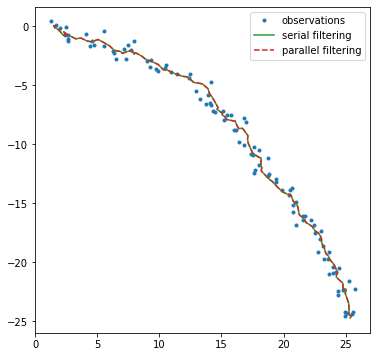

In [ ]:
plt.figure(figsize=(6,6))
plt.plot(*emissions.T,'.', label="observations")
plt.plot(*ssm_posterior.filtered_means[:,:2].T, color="C2", label="serial filtering")
plt.plot(*pfms[:,:2].T, "--", color="C3",label="parallel filtering");
plt.legend();

In [ ]:
np.abs(ssm_posterior.filtered_means - pfms).max()

0.15887868

### Smoothing

In [ ]:
def last_smoothing_element(m, P):
    return jnp.zeros_like(P), m, P

def generic_smoothing_element(params, m, P):
    F = params.dynamics_matrix
    H = params.emission_matrix
    Q = params.dynamics_covariance
    R = params.emission_covariance
    Pp = F @ P @ F.T + Q

    E  = jsc.linalg.solve(Pp, F @ P, assume_a='pos').T
    g  = m - E @ F @ m
    L  = P - E @ Pp @ E.T
    return E, g, L

def make_associative_smoothing_elements(params, filtered_means, filtered_covariances):
    last_elems = last_smoothing_element(filtered_means[-1], filtered_covariances[-1])
    generic_elems = vmap(lambda m, P: generic_smoothing_element(params, m, P))(filtered_means[:-1], filtered_covariances[:-1])
    combined_elems = tree_map(lambda g,l: jnp.append(g,l[None,:],axis=0), generic_elems, last_elems)
    return combined_elems


@vmap
def smoothing_operator(elem1, elem2):
    E1, g1, L1 = elem1
    E2, g2, L2 = elem2

    E = E2 @ E1
    g = E2 @ g1 + g2
    L = E2 @ L1 @ E2.T + L2

    return E, g, L

def parallel_kalman_smoother(params, emissions):
    filtered_means, filtered_covariances = parallel_kalman_filter(params, emissions)
    initial_elements = make_associative_smoothing_elements(params, filtered_means, filtered_covariances)
    final_elements = associative_scan(smoothing_operator, initial_elements, reverse=True)
    return final_elements[1], final_elements[2]

In [ ]:
psms, psPs = parallel_kalman_smoother(lgssm_params, emissions)

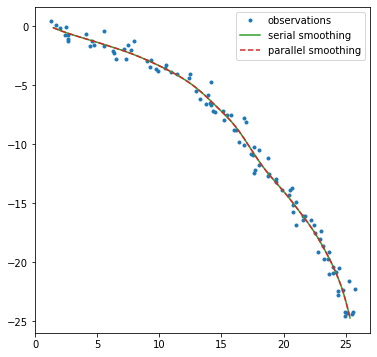

In [ ]:
plt.figure(figsize=(6,6))
plt.plot(*emissions.T,'.', label="observations")
plt.plot(*ssm_posterior.smoothed_means[:,:2].T, color="C2", label="serial smoothing")
plt.plot(*psms[:,:2].T, "--", color="C3",label="parallel smoothing")
plt.legend();


## Timing

In [ ]:
import time

In [ ]:
key = jr.PRNGKey(0)
Ts = [100, 1_000, 10_000, 100_000]
serial_filtering_durations = []
parallel_filtering_durations = []
num_repeats = 5
compiled = False

for T in Ts:
    inputs = jnp.zeros((T,input_dim))
    
    key, subkey = jr.split(key)
    z,emissions = lgssm_sample(subkey,lgssm_params,T, inputs)

    if not compiled:
        ssm_posterior = block_until_ready(lgssm_filter(lgssm_params, emissions, inputs))
        pfilt_means, pfilt_covs = block_until_ready(parallel_kalman_filter(lgssm_params, emissions))
    
    start = time.time()
    for _ in range(num_repeats):
        ssm_posterior = block_until_ready(lgssm_filter(lgssm_params, emissions, inputs))
    end = time.time()
    mean_time = (end-start)/num_repeats
    serial_filtering_durations.append(mean_time)
    print(f"Num timesteps={T}, \t time serial = {mean_time}")
    
    start = time.time()
    for _ in range(num_repeats):
        pfilt_means, pfilt_covs = block_until_ready(parallel_kalman_filter(lgssm_params, emissions))
    end = time.time()
    mean_time = (end-start)/num_repeats
    parallel_filtering_durations.append(mean_time)
    print(f"Num timesteps={T}, \t time parallel = {mean_time}")

Num timesteps=100, 	 time serial = 0.4385208288828532
Num timesteps=100, 	 time parallel = 0.2780752976735433
Num timesteps=1000, 	 time serial = 0.5768963495890299
Num timesteps=1000, 	 time parallel = 0.37906479835510254
Num timesteps=10000, 	 time serial = 1.8795080184936523
Num timesteps=10000, 	 time parallel = 0.5674033164978027
Num timesteps=100000, 	 time serial = 15.201645930608114
Num timesteps=100000, 	 time parallel = 0.6993365287780762
Num timesteps=1000000, 	 time serial = 148.4404614766439
Num timesteps=1000000, 	 time parallel = 0.9188536008199056


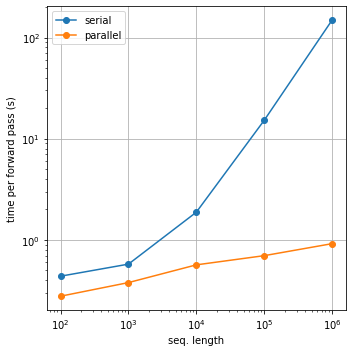

In [ ]:
plt.figure(figsize=(5, 5))
plt.loglog(Ts, serial_filtering_durations, '-o', label='serial')
plt.loglog(Ts, parallel_filtering_durations, '-o', label='parallel')
plt.xticks(Ts)
plt.xlabel("seq. length")
plt.ylabel("time per forward pass (s)")
plt.grid(True)
plt.legend()
plt.tight_layout()

In [ ]:
key = jr.PRNGKey(0)
Ts = [100, 1_000, 10_000, 100_000]
serial_smoothing_durations = []
parallel_smoothing_durations = []
num_repeats = 5
compiled = False

for T in Ts:
    inputs = jnp.zeros((T,input_dim))
    
    key, subkey = jr.split(key)
    z,emissions = lgssm_sample(subkey,lgssm_params,T, inputs)

    if not compiled:
        ssm_posterior = block_until_ready(lgssm_smoother(lgssm_params, emissions, inputs))
        pfilt_means, pfilt_covs = block_until_ready(parallel_kalman_smoother(lgssm_params, emissions))
    
    start = time.time()
    for _ in range(num_repeats):
        ssm_posterior = block_until_ready(lgssm_smoother(lgssm_params, emissions, inputs))
    end = time.time()
    mean_time = (end-start)/num_repeats
    serial_smoothing_durations.append(mean_time)
    print(f"Num timesteps={T}, \t time serial = {mean_time}")
    
    start = time.time()
    for _ in range(num_repeats):
        pfilt_means, pfilt_covs = block_until_ready(parallel_kalman_smoother(lgssm_params, emissions))
    end = time.time()
    mean_time = (end-start)/num_repeats
    parallel_smoothing_durations.append(mean_time)
    print(f"Num timesteps={T}, \t time parallel = {mean_time}")

Num timesteps=100, 	 time serial = 0.7041940212249755
Num timesteps=100, 	 time parallel = 0.36930127143859864
Num timesteps=1000, 	 time serial = 0.9897834300994873
Num timesteps=1000, 	 time parallel = 0.530796480178833
Num timesteps=10000, 	 time serial = 3.2751163959503176
Num timesteps=10000, 	 time parallel = 0.7730414390563964
Num timesteps=100000, 	 time serial = 26.506278562545777
Num timesteps=100000, 	 time parallel = 0.9454202651977539


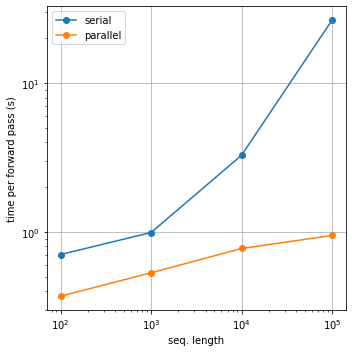

In [ ]:
plt.figure(figsize=(5, 5))
plt.loglog(Ts, serial_smoothing_durations, '-o', label='serial')
plt.loglog(Ts, parallel_smoothing_durations, '-o', label='parallel')
plt.xticks(Ts)
plt.xlabel("seq. length")
plt.ylabel("time per forward pass (s)")
plt.grid(True)
plt.legend()
plt.tight_layout()